## Libraries

NLTK

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Harris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Harris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

spacy

In [3]:
import spacy
!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2022-07-12 20:56:38.045585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-07-12 20:56:38.046459: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Zeugma, Theano (for GloVe embeddings)

In [4]:
from zeugma.embeddings import EmbeddingTransformer

Other modules

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from pprint import pprint

import warnings; warnings.simplefilter('ignore')

## sklearn also has some nice funtions for representations
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Classifiers
# from sklearn.linear_model import SGDClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import LinearSVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC


## and for evaluation
# from sklearn.pipeline import Pipeline
# from sklearn import metrics
# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import cross_val_score

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.base import clone

In [6]:
from pathlib import Path

proj_dir = Path('.')/'..'/'..'
source_data_dir = proj_dir/'data'/'source'
clean_data_dir  = proj_dir/'data'/'clean'

In [7]:
import preprocessing

In [8]:
import json
from datetime import datetime
from pprint import pprint

In [9]:
%load_ext autoreload
%autoreload 2

# 0. Process source files

In [10]:
preprocessing.process_source_files(input_dir = source_data_dir/'pubmed', output_dir = clean_data_dir/'pubmed')

Read 30135 lines from ..\..\data\source\pubmed\test.txt
Wrote 30135 lines to ..\..\data\clean\pubmed\test_processed.txt
Read 180040 lines from ..\..\data\source\pubmed\train.txt
Wrote 180040 lines to ..\..\data\clean\pubmed\train_processed.txt
Read 30212 lines from ..\..\data\source\pubmed\dev.txt
Wrote 30212 lines to ..\..\data\clean\pubmed\dev_processed.txt


# 1. Import data

In [11]:
train_raw, dev_raw, test_raw = preprocessing.import_processed_files(dir=clean_data_dir/'pubmed')

- make experimental datasets (quick)

In [12]:
def sample_df(df, n_pmid = 2):
    pmid_select = df['pmid'].unique().tolist()[0:n_pmid]
    sampled = df.query('pmid in @pmid_select')
    return sampled

TEST_RUN = True
if TEST_RUN:
    N_PMID = 10
    train = sample_df(train_raw, n_pmid=N_PMID)    
    dev   = sample_df(dev_raw, n_pmid=N_PMID)
    test  = sample_df(test_raw, n_pmid=N_PMID)
else:
    train = train_raw.copy()
    dev   = dev_raw.copy()
    test  = test_raw.copy()

- format datasets

In [13]:
train = preprocessing.format_df(train)
dev   = preprocessing.format_df(dev)
test  = preprocessing.format_df(test)

- regexes

In [51]:
with open("regexes.json") as fp:
    regexes = json.load(fp)

pprint(regexes)

{'inside_brackets': '\\(([^\\)]+)\\)',
 'integers_only': '(?<![\\d.])[0-9]+(?![\\d.])'}


# 2. Preprocessing

### 🔴 stopwords

In [14]:
from matplotlib_venn import venn2

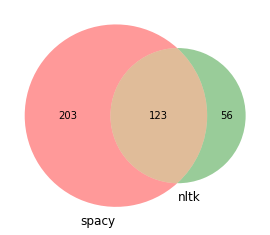

In [15]:
spacy_stopwords = nlp.Defaults.stop_words
nltk_stopwords = set(stopwords.words('english'))

venn2([spacy_stopwords, nltk_stopwords], ['spacy', 'nltk']);

### 🔴 representations

In [16]:
transformers = dict()
transformers['BoW'] = CountVectorizer(
    tokenizer=word_tokenize,  # from nltk
    stop_words=nltk_stopwords,
    max_features=500,
    ngram_range=(1,1) 
)
transformers['tfidf'] = TfidfVectorizer(
    tokenizer=word_tokenize, # from nltk
    stop_words=nltk_stopwords
)
transformers['glove'] = EmbeddingTransformer('glove') # from zeugma

representations = dict()
representations['train'] = dict()
representations['dev']   = dict()
representations['test']  = dict()

for repr_name, transformer in transformers.items():
    ###  transformers within the dictionary are now fitted
    transformer.fit(train['txt'])

    for data_name, dataset in zip(('train', ), (train, )):
        ### transform the dataset
        representation = transformer.transform(dataset['txt'])
        ### formatting
        if type(representation) != np.ndarray:
            representation = representation.toarray() 
        representation = pd.DataFrame(representation)
        ### output
        representations[data_name][repr_name] = representation

- preview the transformed data

In [17]:
representations['train']['glove'].head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.095088,0.075003,-0.340403,0.067870,0.048966,0.005249,0.834002,-0.535745,0.157901,0.147625,...,-0.226524,0.111622,0.153001,-0.029100,-0.495260,-0.345610,0.125865,-0.060836,-0.216941,-0.229318
1,-0.155271,0.142241,-0.092868,-0.181030,0.172117,-0.110830,0.773499,-0.448813,-0.185371,0.029634,...,-0.304260,0.287251,0.170847,0.027117,-0.499730,-0.344393,0.112428,-0.247847,-0.091484,-0.314186
2,-0.151961,-0.069922,-0.689118,0.158852,0.281259,0.045158,0.527157,-1.080880,0.317614,0.012207,...,0.121966,0.099242,0.089910,0.185861,-0.392683,-0.382372,0.078356,0.068270,0.095844,-0.425218
3,0.069870,-0.225407,-0.236780,-0.025364,0.327557,0.198099,0.656091,0.070311,0.348411,0.219523,...,-0.274355,-0.003218,0.459525,-0.168478,-0.093817,-0.344218,-0.222734,0.161007,0.128783,-0.101061
4,0.019597,-0.108223,-0.366440,0.097416,-0.029558,0.082568,0.916761,0.007552,0.225738,0.181114,...,-0.468520,-0.154558,0.110191,-0.146353,-0.305023,-0.254590,-0.142415,-0.066023,-0.001224,-0.186979


- preview features -- are there any abnormalities? uppercase?

In [27]:
BoW_feats = transformers['BoW'].get_feature_names()

In [31]:
train['txt']

24293578_0    To investigate the efficacy of 6 weeks of dail...
24293578_1    A total of 125 patients with primary knee OA w...
24293578_2    Outcome measures included pain reduction and i...
24293578_3    Pain was assessed using the visual analog pain...
24293578_4    Secondary outcome measures included the Wester...
                                    ...                        
25406902_3    In this study , we tested 72 FH + and 32 FH - ...
25406902_4    FH + youths had significantly greater cerebral...
25406902_5    Additionally , FH + youths had moderately slow...
25406902_6    Our findings suggest that global activation in...
25406902_7    This pattern of increased activations in FH + ...
Name: txt, Length: 118, dtype: object

In [35]:
# [w for w in BoW_feats if not w.islower()]
[w for w in BoW_feats if w == 'youths']

['youths']

### 🔴 set up classifiers

In [19]:
pipelines = dict()
pipelines['A'] = Pipeline([
    ('knn', KNeighborsClassifier(n_neighbors=3)),
])
pipelines['B'] = Pipeline([
    ('knn', KNeighborsClassifier(n_neighbors=5)),
])

### 🔴 Run cross validation

In [20]:
CV = 3
SCORE = 'f1_micro'
SEED = 42
rng = np.random.RandomState(SEED)

In [21]:
cv_results = []
run_names  = []
for repr_name, representation in representations['train'].items():
  for pipe_name, pipe in pipelines.items():
      run_name = (repr_name, pipe_name)
      cv_result = cross_val_score(
        pipe,
        X=representation,
        y=train['label'], 
        scoring=SCORE, 
        cv=CV
      )
      cv_results.append(cv_result)
      run_names.append(run_name)

In [22]:
cv_results_df = pd.DataFrame(cv_results, index=run_names)
cv_results_df.index = pd.MultiIndex.from_tuples(run_names, names=['representation', 'pipeline'])
cv_results_df

0         1         2
representation pipeline                           
BoW            A         0.300  0.333333  0.230769
               B         0.325  0.384615  0.256410
tfidf          A         0.525  0.487179  0.512821
               B         0.625  0.435897  0.461538
glove          A         0.425  0.307692  0.487179
               B         0.400  0.307692  0.461538

### 🔴 Best model on test set

In [23]:
best_repr_name = 'tfidf'
best_pipe_name = 'A'

In [24]:
best_transformer = transformers[best_repr_name]
best_pipe    = clone(pipelines[best_pipe_name])

representations['test'][best_repr_name] = best_transformer.transform(test['txt'])

best_pipe.fit(
    X=representations['train'][best_repr_name],
    y=train['label']
)
predicted = best_pipe.predict(representations['test'][best_repr_name])

print(classification_report(test['label'], predicted))

              precision    recall  f1-score   support

  BACKGROUND       0.21      0.36      0.27        11
 CONCLUSIONS       0.60      0.60      0.60        15
     METHODS       0.60      0.30      0.40        40
   OBJECTIVE       0.33      0.14      0.20         7
     RESULTS       0.54      0.75      0.63        40

    accuracy                           0.50       113
   macro avg       0.46      0.43      0.42       113
weighted avg       0.52      0.50      0.48       113



# 3. Experimental

## Spacy language models

- preview what a sentence looks like

In [35]:
spacyoutput = preprocessing.apply_spacy(train2clean['clean'], parser=nlp)
row = spacyoutput.iloc[1, ]
preprocessing.print_row(row)

spacynlp            spacylemma          spacypos            
------------------------------------------------------------
A                   a                   DET                 
total               total               NOUN                
of                  of                  ADP                 
125                 125                 NUM                 
patients            patient             NOUN                
with                with                ADP                 
primary             primary             ADJ                 
knee                knee                NOUN                
OA                  OA                  PROPN               
were                be                  AUX                 
randomized          randomize           VERB                
1:1                 1:1                 NUM                 
;                   ;                   PUNCT               
63                  63                  NUM                 
received            rece

In [41]:
tfidf_transformer = TfidfVectorizer()
tfidf_transformer_fitted = tfidf_transformer.fit(df['txt'])

tfidf_mat   = tfidf_transformer_fitted.transform(df['txt']) # scipy.sparse.csr.csr_matrix
tfidf_feats = tfidf_transformer_fitted.get_feature_names() # list

In [42]:
tfidf_feats

['001',
 '05',
 '10',
 '100',
 '12',
 '125',
 '144',
 '15',
 '18',
 '26',
 '29',
 '34',
 '62',
 '63',
 '65',
 '6mwd',
 '85',
 '86',
 '95',
 'account',
 'actual',
 'ad',
 'adults',
 'affective',
 'after',
 'aim',
 'allocation',
 'an',
 'analog',
 'and',
 'arms',
 'assessed',
 'assessment',
 'assigned',
 'associated',
 'at',
 'attention',
 'attentional',
 'attenuation',
 'based',
 'be',
 'behavior',
 'better',
 'between',
 'bias',
 'biases',
 'both',
 'but',
 'by',
 'caloric',
 'changes',
 'ci',
 'clinical',
 'clinically',
 'clinicaltrials',
 'cognitive',
 'compared',
 'condition',
 'conditions',
 'contribute',
 'contributing',
 'cues',
 'current',
 'daily',
 'day',
 'debq',
 'development',
 'did',
 'difference',
 'differences',
 'disguised',
 'distance',
 'dose',
 'during',
 'dutch',
 'eating',
 'effect',
 'efficacy',
 'either',
 'elevated',
 'emotional',
 'empirical',
 'equivocal',
 'evidence',
 'expected',
 'experimental',
 'experimentally',
 'eye',
 'factor',
 'findings',
 'food',
 '

In [298]:
test.loc[test['txt'].str.contains("0625"), 'txt']

['( Funded by the National Health and Medical Research Council ; ONTRAC Australian New Zealand Clinical Trials Registry number , ACTRN12612000625875 . )',
 'The lowest concentration ( 0.0625 % in 50 ml ) and volume ( 0.5 ml of 1 % solution ) levels of urea solution were obtained that can exert negative influence on the results of helicobacteriosis diagnosis by means of mouth cavity air analysis .']

## 🔴 NUMBERS

- there is some problem with the hyphen not separated by dashes

In [204]:
### NOT USED

if False:
    import string

    exceptions = '.,-'
    punctuations = [char for char in string.punctuation if char not in exceptions]
    punctuations = ''.join(punctuations)
    punctuations

- prep dataset

In [273]:
def find_index(sent):
    flag = train['txt'].str.contains(sent)
    return train.loc[flag].index

def compare_cleaned(row):
    for i in range(train2clean.shape[0]):
        row = train2clean.iloc[i]
        print(row.name)
        print(row['txt'])
        print(row['clean'])
        print('\n', end='')


train2clean = train_raw.copy()
train2clean['clean'] = train2clean['txt'].copy() # make a copy

### subset
## EITHER: find by regex
# indices = find_index("")
# train2clean = train2clean.loc[indices, ]
## OR:     locate by indices
# train2clean = train2clean.iloc[1:2, ]
## OR:     everything
train2clean = train2clean

print(train2clean.shape)
train2clean.head(3)['txt'].tolist()

(180040, 4)


['To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

- apply replacements (regex)

In [274]:
replacements = dict()
replacements['connected_hyphen'] = {
    'regex': f"(?<=[0-9])-(?=[0-9])",
    'replace_to': " - "
}
replacements['truncated_floats'] = {
    'regex': "(?<=[0-9]) \.(?=[0-9])",
    'replace_to': "."
}
replacements['num_comma_separator'] = {
    'regex': "(?<=[0-9]) ,(?=[0-9])",
    'replace_to': ""
}
replacements['flag_integers'] = {
    'regex': "(?<![\\d.])[0-9]+(?![\\d.])",
    'replace_to': "@INTEGER"
}
replacements['flag_floats'] = {
    'regex': "[+-]?(?=\\d*[.eE])([0-9]+\\.?[0-9]*|\\.[0-9]+)([eE][+-]?[0-9]+)?",
    'replace_to': "@FLOAT"
}

steps = [
    'connected_hyphen', 
    'truncated_floats',
    'num_comma_separator',
    'flag_integers',
    'flag_floats'
]
flags = []

for step in steps:
    replacement = replacements[step]
    regex = replacement['regex']
    replace_to = replacement['replace_to']
    
    flag = train2clean['clean'].str.contains(regex)
    print(step, regex, replace_to, len(flag))
    flags.append(flag)
    train2clean['clean'] = train2clean['clean'].str.replace(regex, replace_to)


compare_cleaned(train2clean)

connected_hyphen (?<=[0-9])-(?=[0-9])  -  180040
truncated_floats (?<=[0-9]) \.(?=[0-9]) . 180040
num_comma_separator (?<=[0-9]) ,(?=[0-9])  180040
flag_integers (?<![\d.])[0-9]+(?![\d.]) @INTEGER 180040
flag_floats [+-]?(?=\d*[.eE])([0-9]+\.?[0-9]*|\.[0-9]+)([eE][+-]?[0-9]+)? @FLOAT 180040


In [67]:
with open("regexes.json") as fp:
    regexes = json.load(fp)
    
regex = regexes['integers_only']
finds = exp['txt'].str.findall(regex)

for i in range(exp.shape[0]):
    txt = exp.iloc[i]['txt']
    find = finds.iloc[i]
    print(find, '\n', txt, end='\n\n')

['6', '6'] 
 There was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and 6MWD at 6 weeks .

['95', '18', '15', '26', '144'] 
 The mean difference between treatment arms ( 95 % CI ) was 10.9 ( 4.8-18 .0 ) , p < 0.001 ; 9.5 ( 3.7-15 .4 ) , p < 0.05 ; 15.7 ( 5.3-26 .1 ) , p < 0.001 ; and 86.9 ( 29.8-144 .1 ) , p < 0.05 , respectively .

['1', '6', '6'] 
 Further , there was a clinically relevant reduction in the serum levels of IL-1 , IL-6 , TNF - , and hsCRP at 6 weeks in the intervention group when compared to the placebo group .

['12'] 
 These differences remained significant at 12 weeks .

['65', '34'] 
 The Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was 65 % in the intervention group and 34 % in the placebo group ( p < 0.05 ) .

[] 
 Hierarchical multivariate regression modeling showed that self-reported emotional eating did not accou

## 🔴 Tense?

# Section header

- any 

In [170]:
lemma_counts = (
    df[['label', 'spacylemma']]
    .explode('spacylemma')
)
lemma_crosstab = pd.crosstab(index=lemma_counts['spacylemma'], columns=lemma_counts['label'])

In [236]:
for token in ['randomized', 'randomised', 'randomization']:
    print(lemma_crosstab.loc[token])

label
BACKGROUND      590
CONCLUSIONS     305
METHODS        4068
OBJECTIVE       553
RESULTS         245
Name: randomized, dtype: int64
label
BACKGROUND     151
CONCLUSIONS     46
METHODS        744
OBJECTIVE       64
RESULTS         50
Name: randomised, dtype: int64
label
BACKGROUND      13
CONCLUSIONS     29
METHODS        523
OBJECTIVE       15
RESULTS        217
Name: randomization, dtype: int64


In [187]:
from nltk.stem.snowball import SnowballStemmer

In [45]:
import requests
import re


def britishize(string, us2uk_dict=None):
    if us2uk_dict is None:
        url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/american_spellings.json"
        us2uk_dict = requests.get(url).json()    

    for us, uk in us2uk_dict.items():
        string = string.replace(us, uk) 
    return string

url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/american_spellings.json"
us2uk_dict = requests.get(url).json()



example_sent = u'Diskcount discount disk disc randomisation randomization randomised'
print(example_sent)
britishize(example_sent)
    

Diskcount discount disk disc randomisation randomization randomised


'Diskcount discount disc disc randomisation randomization randomised'

In [230]:
[word for word in us2uk_dict.keys() if 'random' in word]

['randomize', 'randomized', 'randomizes', 'randomizing']

In [234]:
example_sent = nlp(u'Randomisation randomized compute computed')

for word in example_sent:
    print(word.text + '  ===>', word.lemma_)

Randomisation  ===> randomisation
randomized  ===> randomize
compute  ===> compute
computed  ===> compute


In [ ]:
stemmer = SnowballStemmer(language='english')

tokens = ['compute', 'computer', 'computed', 'computing']

for token in tokens:
    print(token + ' --> ' + stemmer.stem(token))